# Map Matching Benchmarks

This notebook is intended as a supplement to the Sendai Map notebook. This notebook implements the competing map matching algorithms and tests them against the map-matching-dataset for comparison.

In [1]:
import networkx as nx
import osmnx as ox 
import time
from shapely.geometry import Polygon, Point
import os
import ujson as json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from algorithms import mm_utils
import dask
from functools import reduce
from scipy.optimize import linprog
from scipy.sparse import csr_matrix


# Remove this when debugging
#import warnings
#warnings.filterwarnings('ignore')

import dask.bag as db

%matplotlib inline
#ox.__version__

ERROR 1: /usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
ERROR 1: /usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: /usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZN5arrow2fs10FileSystem13NormalizePathENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
ERROR 1: /usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZN5arrow2fs10FileSystem13NormalizePathENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE


In [2]:
# Data Input

df_track = db.read_text('Data/map-matching-dataset/*track.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_network_edges = db.read_text('Data/map-matching-dataset/*arcs.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_network_nodes = db.read_text('Data/map-matching-dataset/*nodes.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)
df_gt = db.read_text('Data/map-matching-dataset/*route.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)

In our case, our data is already fused. But often you will have several datasets with asynchronous data that you will have to fuse first. We implemented a barebones method in mm_utils to handle this; you can see an example of how to use it in '02a Data Pre-Processing'.

Typically GPS/IMU data is recorded as Point geometries in a GDF.
However, some algorithms require a trajectory (LineStrings) despite this.
As a result, our framework requires both points (nodes) and trajectories (edges).
So we will need to create a "trajectory" by sequentially connecting our nodes

In [3]:
# I wrote a utility function to do that, provided in mm_utils.

df_track_edges = df_track.map(mm_utils.point_to_traj)#, columns = {'timestamp':'first',
                                                     #  'altitude':'average',
                                                     #  'speed':'average',
                                                     #  'vertical accuracy':'last',
                                                     #  'horizontal accuracy':'last',
                                                     #  'oops':'notavalidmethod'})

There may be other data assigned to the nodes which we would like the edges to also reflect.
Some algorithms may use the auxiliary data from edges, which is why this is a concern.
There's no perfect way to do this assignment, but I included a few basic methods in mm_utils: 'first' node assignment, 'average' between nodes, and 'last' node assignment. That is the columns argument I used above.

Now we demonstrate how we can work with several algorithms at once in a modular fashion.

First we initialize the simulators, to be later applied.

In [ ]:
from algorithms import metric_mm#, fmm_bin 
#from fmm import FastMapMatchConfig

### Define map matching configurations

k = 8
radius = 0.003
gps_error = 0.0005

#fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None

## Least squares functions
ls_ri = lambda distarray: np.square(distarray) # The function applied directly to the distances from the candidate route to the k-NN GPS coords
ls_ro = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray)) # This is where we 'integrate' over the distances, and if we need to do anything else, we do it
ls_gi = lambda distarray: np.square(distarray) # The function applied directly to the distances from the GPS coords to the k-NN candidate route nodes
ls_go = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray))
##

## Inverse squares function ('Electrical method')
eps = 0.0000001
is_ri = lambda distarray: np.power(np.square(distarray) + eps, -1) # We need eps to prevent singularities, i.e. r = 0
is_ro = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray)) # We sum, and then multiply by -1 to turn the minimizing process into a maximizing process
is_gi = lambda distarray: np.power(np.square(distarray) + eps, -1)
is_go = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray))
##

def wrapper_f(ri, ro, gi, go): # This should return a function composed from the basic functions, that can then be applied onto route and gps data.
    return lambda route, gps : 1*ro(ri(route)) + 1*go(gi(gps))

ls_loss_function = wrapper_f(ls_ri, ls_ro, ls_gi, ls_go)
is_loss_function = wrapper_f(is_ri, is_ro, is_gi, is_go)

def wasserstein(routeloss, gpsloss):#gpsloss,n,m
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    # n is the number of points along the trajectory
    # m is the number of points on the candidate route
    n = gpsloss.shape[0]
    m = gpsloss.shape[1]
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    #Create equality constraints
    b = [1/n for i in range(0,n)]+ [1/m for i in range(0,m)]
    row1 = [i for i in range(0,n) for j in range(0,m)]
    row2 = [n+j for j in range (0,m) for i in range(0,n)]
    row = np.append(np.matrix.flatten(np.array(row1)),np.matrix.flatten(np.array(row2)))
    col1 = [list(range(0,n*m))]
    col2 =  [j+m*k for j in range(0,m) for k in range(0,n)]
    col = np.append(np.matrix.flatten(np.array(col1)),np.matrix.flatten(np.array(col2)))
    data = np.ones(n*m*2)
    A = csr_matrix((data, (row, col)),shape = (n+m, n*m)).toarray()
    A = A[:-1]
    b = b[:-1]
    #solve the linear program
    res = linprog(np.matrix.flatten(gpsloss),None, None,A,b)
    #return the function value, i.e. the wasserstein distance
    loss = res.fun
    return loss

In [ ]:
# The metric_mm algorithm allows you to either directly pass in a loss function, or to pass it all the individual pieces and wrap it itself
# This may be useful in case you wish to utilize the individual functions of a sim elsewhere.

#sim1 = fmm_bin.FMM(cfg = fmm_config)
sim2 = metric_mm.Sim(ls_ri, ls_ro, ls_gi, ls_go, wrapper_f) # Least squares metric-based
sim3 = metric_mm.Sim(loss_function = is_loss_function)
sim4 = metric_mm.Sim(loss_function = wasserstein)


## If you have the ground truth, load it here
ground_truth = db.read_text('Data/map-matching-dataset/*route.geojson').map(json.loads).map(gpd.GeoDataFrame.from_features)

In [5]:
## We will convert our Dask Bags to Dask Delayed objects so we can iterate over them. Then we will lazily call our function on our dataset
# Finally we will compute our results, and Dask will automatically parallelize our work.

gt = ground_truth.to_delayed()
te = df_track_edges.to_delayed()
tn = df_track.to_delayed()
ne = df_network_edges.to_delayed()
nn = df_network_nodes.to_delayed()

In [ ]:
%%time
# We will precompute candidate routes for the first ten datasets, and then save them. This will greatly speed up the runtime of the metric-based loss methods and the Wasserstein loss methods.

for i in range(100):
    
    if not os.path.exists('Data/map-matching-dataset/0000000' + str(i) + 'candroutes.geojson'):
    
        network_edges = ne[i].compute()[0]
        track_nodes = tn[i].compute()[0]
                
        qry_pts = [y for sublist in [x.coords[:] for x in network_edges['geometry']] for y in sublist]            
        source_index, _ = mm_utils.get_nearest([(track_nodes['geometry'].iloc[0].x, track_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
        source_index = source_index[0][0]
        target_index, _ = mm_utils.get_nearest([(track_nodes['geometry'].iloc[-1].x, track_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
        target_index = target_index[0][0]

        source = Point(qry_pts[source_index])
        target = Point(qry_pts[target_index])

        candidates = mm_utils.get_nearest_edges(track_nodes, network_edges, k_neighbors=8, r = 0.1) 
        all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)
        try:
            candidate_routes, _ = mm_utils.dijkstra(source, target, all_candidate_edges) # This is the bottleneck in this situation. I wish I had time to write an informed Dijkstra method
            with open('Data/map-matching-dataset/0000000' + str(i) + 'candroutes.geojson', 'w') as f:
                for j, item in enumerate(candidate_routes):
                    if j > 0:
                        f.write('\n')
                    f.write('%s' % item.to_json())
                # Note that each line of the GeoJSON file is valid GeoJSON, but the file as a whole is not valid GeoJSON.
        except:
            with open('Data/map-matching-dataset/0000000' + str(i) + 'candroutes.geojson', 'w') as f:
                f.write('\n')
                # Create a blank file, so we won't try to run it again on it.

/home/gjgress/.local/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/home/gjgress/.local/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/home/gjgress/.local/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/home/gjgress/.local/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/home/gjgress/.local/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
/home/gjgress/.local/lib/python3.10/site-packages/shapely/measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a,

In [ ]:
# In theory, the above code can be parallelized. But there are some current issues with the method, so this will need adjusting before it can be improved further

# %%time
# # We will precompute candidate routes for the first ten datasets, and then save them. This will greatly speed up the runtime of the metric-based loss methods and the Wasserstein loss methods.

# all_cands = []

# n = 10

# for i in range(n):
    
#     if not os.path.exists('map-matching-dataset/0000000' + str(i) + 'candroutes.geojson'):
    
#         network_edges = ne[i].compute()[0]
#         track_nodes = tn[i].compute()[0]
                
#         qry_pts = [y for sublist in [x.coords[:] for x in network_edges['geometry']] for y in sublist]            
#         source_index, _ = mm_utils.get_nearest([(track_nodes['geometry'].iloc[0].x, track_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
#         source_index = source_index[0][0]
#         target_index, _ = mm_utils.get_nearest([(track_nodes['geometry'].iloc[-1].x, track_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
#         target_index = target_index[0][0]

#         source = Point(qry_pts[source_index])
#         target = Point(qry_pts[target_index])

#         candidates = mm_utils.get_nearest_edges(track_nodes, network_edges, k_neighbors=16, r = 0.1) 
#         all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)
#         candidate_routes = dask.delayed(mm_utils.dijkstra)(source, target, all_candidate_edges) # This is the bottleneck in this situation. I wish I had time to write an informed Dijkstra method
#         all_cands.append(candidate_routes)

# dask.compute(all_cands)

In [ ]:
# network_edges = ne[9].compute()[0]
# track_nodes = tn[9].compute()[0]
                
# qry_pts = [y for sublist in [x.coords[:] for x in network_edges['geometry']] for y in sublist]            
# source_index, _ = mm_utils.get_nearest([(track_nodes['geometry'].iloc[0].x, track_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
# source_index = source_index[0][0]
# target_index, _ = mm_utils.get_nearest([(track_nodes['geometry'].iloc[-1].x, track_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
# target_index = target_index[0][0]

# source = Point(qry_pts[source_index])
# target = Point(qry_pts[target_index])

# candidates = mm_utils.get_nearest_edges(track_nodes, network_edges, k_neighbors=16, r = 0.1) 
# all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)

# candidate_routes, _ = mm_utils.dijkstra(source, target, all_candidate_edges) # This is the bottleneck in this situation. I wish I had time to write an informed Dijkstra method


In [9]:
# When we want to reconstruct this list, we do the following:

all_cands = []

for i in range(100):
    cand_routes = []
    with open('Data/map-matching-dataset/0000000'+ str(i) + 'candroutes.geojson', 'r') as f:
        lines = f.readlines()
        for line in lines:
            gjson = json.loads(line)
            cand_routes.append(gpd.GeoDataFrame.from_features(gjson))
    all_cands.append(cand_routes)
    

FileNotFoundError: [Errno 2] No such file or directory: 'map-matching-dataset/00000001candroutes.geojson'

Now we are ready to run the simulator on a subsection (or all of) the data. It is easy to run algorithms in parallel-- all of the parallelization is handled by Dask Delayed, as the problem is embarrasingly parallel.

One small caveat: even if your algorithm is embarrassingly parallelizable, if you utilize python.os functions, you may run into I/O read/write errors. To circumvent this, use a dedicated library such as tempfile to systematically handle the temp file creation.

In [9]:
## Let's see this in action
sim2_results = []
sim3_results = []
#sim4_results = [] # This one is currently too slow to utilize

n = 100

for i in range(n):
    
    ite = te[i].compute()[0]
    itn = tn[i].compute()[0]
    ine = ne[i].compute()[0]
    inn = nn[i].compute()[0]
    
    # Load candidate routes
    
    cand_routes = []
    with open('Data/map-matching-dataset/0000000' + str(i) + 'candroutes.geojson', 'r') as f:
        lines = f.readlines()
        for line in lines:
            gjson = json.loads(line)
            cand_routes.append(gpd.GeoDataFrame(gjson))
#    %timeit sim1_results.append(sim1.run(ite, itn, ine, inn, return_results=True))
    
    %timeit sim2.preprocessing(ite, ine, candidate_routes = all_cands[i], n = 10, m = 1)
    %timeit sim2_results.append(sim2.run(k1 = 10, k2 = 10, return_results = True)[0])
    
    %timeit sim3.preprocessing(ite, ine, candidate_routes = all_cands[i], n = 10, m = 1)
    %timeit sim3_results.append(sim3.run(k1 = 10, k2 = 10, return_results = True)[0])
    
#    %timeit sim4.preprocessing(ite, ine, candidate_routes = all_cands[i], n = 1, m = 1)
#    %timeit sim4_results.append(sim4.run(k1 = 1, k2 = -1, return_results = True)[0])    

2min 37s ± 31.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.2 s ± 540 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2min 40s ± 5.24 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.6 s ± 615 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8min 18s ± 28.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.1 s ± 595 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7min 53s ± 22.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.1 s ± 332 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now we iterate through our results, and evaluate it using the build-in evaluation method in mm_utils.

In [50]:
#sim1_errors = []
sim2_errors = []
sim3_errors = []
#sim4_errors = []

for i in range(n):
#    errors.append(dask.delayed(mm_utils.evaluate)(sim1_results[i],gt[i], matchid = "index")) # A more standard match method would be 'geometry', but in this case index is more reliable
# For whatever reason, delayed isn't working here, so I'm just going to do this manually
#    sim1_errors.append(mm_utils.evaluate(sim1_results[i],
#                                    gt[i].compute()[0],
#                                    matchid = "index")) # A more standard match method would be 'geometry', but in this case index is more reliable
    sim2_errors.append(mm_utils.evaluate(sim2_results[i*8],
                                    gt[i].compute()[0],
                                    matchid = "geometry"))
    sim3_errors.append(mm_utils.evaluate(sim3_results[i*8],
                                    gt[i].compute()[0],
                                    matchid = "geometry"))
#    sim4_errors.append(mm_utils.evaluate(sim4_results[i],
#                                    gt[i].compute()[0],
#                                    matchid = "index"))

In [ ]:
# fig = plt.figure(1)
# plt.boxplot(sim1_errors,vert=False)
# plt.title('FMM Error %s on ' 
#           + str(n) 
#           + ' test cases \n(Average error = ' 
#           + str(np.average(sim1_errors)) + ')')
# plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7e60fde950>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7e60fdee60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7e60fde650>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7e60ff41c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7e60ff44c0>],
 'means': []}

Text(0.5, 1.0, 'Least Squares Error %s on 2 test cases \n(Average error = 0.06099783401210838)')

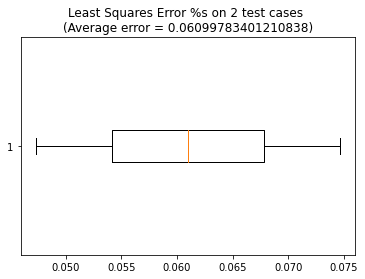

In [52]:
fig = plt.figure(1)
plt.boxplot(sim2_errors,vert=False)
plt.title('Least Squares Error %s on ' 
          + str(n) 
          + ' test cases \n(Average error = ' 
          + str(np.average(sim2_errors)) + ')')
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7e60f74fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7e60f75570>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7e60f74d00>],
 'medians': [<matplotlib.lines.Line2D at 0x7f7e60f75b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f7e60f75de0>],
 'means': []}

Text(0.5, 1.0, 'Electrical Method Error %s on 2 test cases \n(Average error = 0.013010332217188662)')

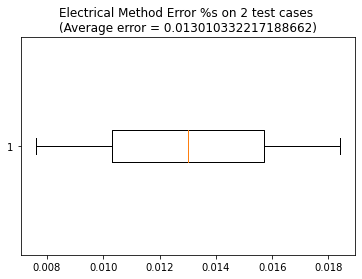

In [53]:
fig = plt.figure(1)
plt.boxplot(sim3_errors,vert=False)
plt.title('Electrical Method Error %s on ' 
          + str(n) 
          + ' test cases \n(Average error = ' 
          + str(np.average(sim3_errors)) + ')')
plt.show()

In [ ]:
# fig = plt.figure(1)
# plt.boxplot(sim4_errors,vert=False)
# plt.title('Wasserstein Error %s on ' 
#           + str(n) 
#           + ' test cases \n(Average error = ' 
#           + str(np.average(sim4_errors)) + ')')
# plt.show()

Overall, FMM seems to handle itself okay, with the exception of one huge outlier!

(Note-- having an error above 100% is not a bug; the standard error formula is not upper-bounded, despite being a percentage)

Let's see how they performed on one datapoint.

In [ ]:
k = 4
fig, axs = plt.subplots(2,k, figsize=(24,16))

fig.suptitle('Evaluation Methods Visualized')

# netemp = ne[0].compute()[0]
# gttemp = gt[0].compute()[0]
# netemp.plot(ax=axs[0,0])
# tn[0].compute()[0].plot(ax=axs[0,0], color='black',markersize=2)
# netemp.plot(ax=axs[1,0])
# gttemp.plot(ax=axs[1,0], color='green')
# netemp.plot(ax=axs[2,0])
# sim1_results[0].plot(ax=axs[2,0], color= 'red')
# evalint = gttemp.loc[np.intersect1d(gttemp['index'], sim1_results[0]['index'], return_indices=True)[1]]
# evalxor = pd.concat([gttemp.overlay(evalint, how="difference"), sim1_results[0].overlay(evalint, how = "difference")])
# evalxor.plot(ax=axs[3,0], color='purple')
# axs[3,0].text(0.5, -0.5, 'Error: ' + str(sim1_errors[0]), size=10, ha= 'center', transform=axs[3,0].transAxes)

netemp = ne[0].compute()[0]
gttemp = gt[0].compute()[0]
netemp.plot(ax=axs[0,0])
tn[0].compute()[0].plot(ax=axs[0,0], color='black',markersize=2)
netemp.plot(ax=axs[1,0])
gttemp.plot(ax=axs[1,0], color='green')
netemp.plot(ax=axs[2,0])
sim2_results[0].plot(ax=axs[2,0], color= 'red')
evalint = gttemp.loc[np.intersect1d(gttemp['index'], sim2_results[0]['index'], return_indices=True)[1]]
evalxor = pd.concat([gttemp.overlay(evalint, how="difference"), sim2_results[0].overlay(evalint, how = "difference")])
evalxor.plot(ax=axs[3,0], color='purple')
axs[3,0].text(0.5, -0.5, 'Error: ' + str(sim2_errors[0]), size=10, ha= 'center', transform=axs[3,0].transAxes)

netemp = ne[0].compute()[0]
gttemp = gt[0].compute()[0]
netemp.plot(ax=axs[0,1])
tn[0].compute()[0].plot(ax=axs[0,1], color='black',markersize=2)
netemp.plot(ax=axs[1,1])
gttemp.plot(ax=axs[1,1], color='green')
netemp.plot(ax=axs[2,1])
sim3_results[0].plot(ax=axs[2,1], color= 'red')
evalint = gttemp.loc[np.intersect1d(gttemp['index'], sim3_results[0]['index'], return_indices=True)[1]]
evalxor = pd.concat([gttemp.overlay(evalint, how="difference"), sim3_results[0].overlay(evalint, how = "difference")])
evalxor.plot(ax=axs[3,1], color='purple')
axs[3,1].text(0.5, -0.5, 'Error: ' + str(sim3_errors[0]), size=10, ha= 'center', transform=axs[3,1].transAxes)

# netemp = ne[0].compute()[0]
# gttemp = gt[0].compute()[0]
# netemp.plot(ax=axs[0,2])
# tn[0].compute()[0].plot(ax=axs[0,2], color='black',markersize=2)
# netemp.plot(ax=axs[1,2])
# gttemp.plot(ax=axs[1,2], color='green')
# netemp.plot(ax=axs[2,2])
# sim4_results[0].plot(ax=axs[2,2], color= 'red')
# evalint = gttemp.loc[np.intersect1d(gttemp['index'], sim4_results[0]['index'], return_indices=True)[1]]
# evalxor = pd.concat([gttemp.overlay(evalint, how="difference"), sim3_results[0].overlay(evalint, how = "difference")])
# evalxor.plot(ax=axs[3,2], color='purple')
# axs[3,2].text(0.5, -0.5, 'Error: ' + str(sim4_errors[0]), size=10, ha= 'center', transform=axs[3,2].transAxes)


fig.legend(handles=[axs[0,0].collections[0],axs[0,0].collections[1],axs[1,0].collections[1],axs[2,0].collections[1],axs[3,0].collections[0]], labels = ['Road Network', 'GPS Datapoints', 'Ground Truth', 'Prediction', 'Difference between GT and Pred.'], loc = 'lower left')
plt.savefig("Outputs/casestudy.png",bbox_inches='tight',dpi=100) 
plt.subplots_adjust(hspace=0.5)